In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tornettools.plot

from collections import defaultdict

from tornettools.parse_tgen import extract_tgen_plot_data
from tornettools.plot import __load_tornet_datasets
from tornettools.plot import __load_torperf_datasets
from tornettools.plot import __plot_transfer_time
from tornettools.plot import __plot_circuit_build_time
from tornettools.plot import __plot_round_trip_time
from tornettools.plot import __plot_memory_usage

from wand.image import Image as WImage

In [3]:
def expand(path):
    return os.path.abspath(os.path.expanduser(path))

def __plot_finish(args, lines, labels, filename):
    if 'RAM' in plt.gca().get_ylabel():
        plt.ylim(0, 600)
    plt.tick_params(axis='both', which='major', labelsize=25)
    plt.tick_params(axis='both', which='minor', labelsize=20)
    plt.grid(True, axis='both', which='minor', color='0.1', linestyle=':', linewidth='0.5')
    plt.grid(True, axis='both', which='major', color='0.1', linestyle=':', linewidth='1.0')

    plt.legend(lines, labels, loc='best')
    plt.tight_layout(pad=0.3)
    plt.savefig(f"{args.prefix}/paper-performance-{filename}.{'png' if args.plot_pngs else 'pdf'}")    
    plt.close()
    
# Overwrite finish function to change tick font size and don't save a summary pdf
tornettools.plot.__plot_finish = __plot_finish

class Args:
    def __init__(self, prefix, labels, paths):
        for idx, path in enumerate(paths):
            paths[idx] = expand(path)
        self.prefix = expand(prefix)
        self.plot_pngs = False
        self.labels = labels
        self.colors = None
        self.tornet_collection_path = paths
    
dir = '../../tor-neverenough/experiments/active-links-0.3.5.18/data'
 
args = Args(
    prefix='./', 
    labels=[
        'PCTLS',
        'Vanilla',
        'PCTLS (loss)',
        'Vanilla (loss)',
    ],
    paths=[
        f'{dir}/0.25-kist-pctcp',
        f'{dir}/0.25-kist',
        f'{dir}/0.25-kist-pctcp-loss',
        f'{dir}/0.25-kist-loss',
    ]
)

import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Change plots to our "look and feel"
plt.rc('font', family='cmr10')
plt.rc('font', size=40)
plt.rc('axes', axisbelow=True)
plt.rc('axes.formatter', use_mathtext=True)
plt.rc('figure', figsize=(16, 10))

def add_n(dbs):
    for idx, db in enumerate(dbs):
        n = len(db['dataset'])
        dbs[idx]['label'] += ' (n=%d)' % n

In [4]:
tornet_dbs = __load_tornet_datasets(args, "resource_usage.json")
add_n(tornet_dbs)
__plot_memory_usage(args, tornet_dbs)

ram_usage = defaultdict(list)
for db in tornet_dbs:
    for dataset in db['dataset']:
        ram_usage[db['label']].append(dataset['ram']['gib_used_max'])
                                                      
pd.DataFrame.from_dict(ram_usage, orient='index').T

PCTLS (n=10)  Vanilla (n=10)  PCTLS (loss) (n=10)  Vanilla (loss) (n=10)
0    524.325184      430.461414           578.537113             500.213642
1    528.076595      430.314438           569.602165             502.052357
2    527.591152      431.861649           572.654957             505.327473
3    526.876278      431.697910           577.929607             512.073124
4    527.413612      432.964588           578.369720             508.836208
5    527.721062      431.934795           572.366451             503.026985
6    527.121777      431.878220           573.346828             508.485138
7    525.265697      431.756889           571.877186             521.071609
8    525.164589      431.351456           581.687664             503.462917
9    526.498562      432.164047           574.097984             506.968109

In [5]:
one = "PCTLS (n=10)"
two = "Vanilla (n=9)"
three = "PCTLS (loss) (n=10)"
four = "Vanilla (loss) (n=10)"

In [6]:
torperf_dbs = []
tornet_dbs = __load_tornet_datasets(args, "perfclient_circuit_build_time.json")
add_n(tornet_dbs)
__plot_circuit_build_time(args, torperf_dbs, tornet_dbs)

circuit_time = defaultdict(list)

for db in tornet_dbs:
    for dataset in db['dataset']:
        circuit_time[db['label']].append(np.mean(dataset))
            
circuit_time = pd.DataFrame.from_dict(circuit_time, orient='index').T

circuit_time['Difference'] = circuit_time[one] - circuit_time[two]
circuit_time['Difference (loss)'] = circuit_time[three] - circuit_time[four]
circuit_time['Difference PCTLS'] = circuit_time[three] - circuit_time[one]


circuit_time

PCTLS (n=10)  Vanilla (n=9)  PCTLS (loss) (n=10)  Vanilla (loss) (n=10)  \
0      2.162544       1.388294             2.200973               1.676947   
1      2.083098       1.360947             2.097234               1.673040   
2      2.082012       1.482551             2.305488               1.742869   
3      2.204695       1.417307             2.314673               1.780279   
4      2.205811       1.455633             2.111899               1.790115   
5      2.095125       1.400575             2.250299               1.638414   
6      2.219403       1.451147             2.176972               1.636856   
7      2.149854       1.435459             2.192352               1.778978   
8      2.156735       1.433840             2.181448               1.755578   
9      2.210652            NaN             2.252535               1.657598   

   Difference  Difference (loss)  Difference PCTLS  
0    0.774250           0.524026          0.038430  
1    0.722151           0.424194          0.014136  
2    0.599461           0.562619          0.223475  
3    0.787388           0.534394          0.109978  
4    0.750178           0.321783         -0.093912  
5    0.694550           0.611884          0.155174  
6    0.768256           0.540116         -0.042431  
7    0.714395           0.413374          0.042498  
8    0.722895           0.425870          0.024713  
9         NaN           0.594937          0.041883

Circuit build time for Vanilla + PCTLS is always slower, because every circuit has it's own TLS connection.
Overall it is 0.73 seconds slower.

In [7]:
(
circuit_time['Difference'].mean(),
circuit_time['Difference'].std(),
circuit_time['Difference (loss)'].mean(),
circuit_time['Difference (loss)'].std(),
circuit_time['Difference PCTLS'].mean(),
circuit_time['Difference PCTLS'].std(),
)

(0.7259471696857358,
 0.05659829621652171,
 0.4953198128437008,
 0.09375480617378462,
 0.051394417413940775,
 0.09199576299816668)

In [8]:
(
circuit_time['Difference'].mean(),
circuit_time['Difference (loss)'].mean()
)

(0.7259471696857358, 0.4953198128437008)

In [9]:
one = "PCTLS (n=10)"
two = "Vanilla (n=10)"
three = "PCTLS (loss) (n=10)" 
four = "Vanilla (loss) (n=10)"

In [10]:
tornet_dbs = __load_tornet_datasets(args, "time_to_last_byte_recv.json")
add_n(tornet_dbs)
__plot_transfer_time(args, torperf_dbs, tornet_dbs, "51200")
__plot_transfer_time(args, torperf_dbs, tornet_dbs, "1048576")
__plot_transfer_time(args, torperf_dbs, tornet_dbs, "5242880")

In [11]:
transfer_time = defaultdict(list)

for db in tornet_dbs:
    for dataset in db['dataset']:
        for size in dataset:
            if size == 'ALL':
                continue
            transfer_time['size'].append(size)
            transfer_time[db['label']].append(np.mean(dataset[size]))
            
transfer_time = pd.DataFrame.from_dict(transfer_time, orient='index').T

transfer_time['Difference'] = transfer_time[one] - transfer_time[two]
transfer_time['Difference (loss)'] = transfer_time[three] - transfer_time[four]

In [12]:
transfer_time

size PCTLS (n=10) Vanilla (n=10) PCTLS (loss) (n=10)  \
0    1048576     3.307853       3.268539            8.897874   
1      51200     1.337565        1.31278            1.445716   
2    5242880     9.255998       9.849149           46.194605   
3    1048576     3.227635       3.425887            8.624544   
4      51200     1.318431       1.366305            1.432513   
..       ...          ...            ...                 ...   
115    51200         None           None                None   
116  5242880         None           None                None   
117  1048576         None           None                None   
118    51200         None           None                None   
119  5242880         None           None                None   

    Vanilla (loss) (n=10) Difference Difference (loss)  
0               10.334779   0.039313         -1.436905  
1                1.596461   0.024785         -0.150744  
2               52.086496  -0.593152         -5.891891  
3               10.322714  -0.198252          -1.69817  
4                1.639685  -0.047874         -0.207173  
..                    ...        ...               ...  
115                  None        NaN               NaN  
116                  None        NaN               NaN  
117                  None        NaN               NaN  
118                  None        NaN               NaN  
119                  None        NaN               NaN  

[120 rows x 7 columns]

In [13]:
transfer_time['size'].unique()

array(['1048576', '51200', '5242880'], dtype=object)

In [14]:
(transfer_time[transfer_time['size'] == '51200']['Difference'].mean(), 
 transfer_time[transfer_time['size'] == '1048576']['Difference'].mean(), 
 transfer_time[transfer_time['size'] == '5242880']['Difference'].mean())

(-0.0385274443250682, -0.14982789871757723, -0.7030286023964907)

In [15]:
(transfer_time[transfer_time['size'] == '51200']['Difference (loss)'].mean(), 
 transfer_time[transfer_time['size'] == '1048576']['Difference (loss)'].mean(), 
 transfer_time[transfer_time['size'] == '5242880']['Difference (loss)'].mean())

(-0.17177167467734292, -1.7644319972915716, -5.695986414477732)

In [16]:
(transfer_time[transfer_time['size'] == '51200'][two].mean()/transfer_time[transfer_time['size'] == '51200'][one].mean(),
 transfer_time[transfer_time['size'] == '1048576'][two].mean()/transfer_time[transfer_time['size'] == '1048576'][one].mean(),
 transfer_time[transfer_time['size'] == '5242880'][two].mean()/transfer_time[transfer_time['size'] == '5242880'][one].mean())

(1.0292976894222028, 1.0461718588019275, 1.075867674452193)

In [17]:
(transfer_time[transfer_time['size'] == '51200'][one].mean()/transfer_time[transfer_time['size'] == '51200'][two].mean(),
 transfer_time[transfer_time['size'] == '1048576'][one].mean()/transfer_time[transfer_time['size'] == '1048576'][two].mean(),
 transfer_time[transfer_time['size'] == '5242880'][one].mean()/transfer_time[transfer_time['size'] == '5242880'][two].mean())

(0.9715362331779359, 0.9558658948685511, 0.9294823366722836)

In [18]:
(transfer_time[transfer_time['size'] == '51200'][four].mean()/transfer_time[transfer_time['size'] == '51200'][three].mean(),
 transfer_time[transfer_time['size'] == '1048576'][four].mean()/transfer_time[transfer_time['size'] == '1048576'][three].mean(),
 transfer_time[transfer_time['size'] == '5242880'][four].mean()/transfer_time[transfer_time['size'] == '5242880'][three].mean())

(1.1171187863574075, 1.1963305011237442, 1.1224287781055169)

In [19]:
(transfer_time[transfer_time['size'] == '51200'][three].mean()/transfer_time[transfer_time['size'] == '51200'][four].mean(),
 transfer_time[transfer_time['size'] == '1048576'][three].mean()/transfer_time[transfer_time['size'] == '1048576'][four].mean(),
 transfer_time[transfer_time['size'] == '5242880'][three].mean()/transfer_time[transfer_time['size'] == '5242880'][four].mean())

(0.8951599527394065, 0.8358894127172, 0.8909251255013638)

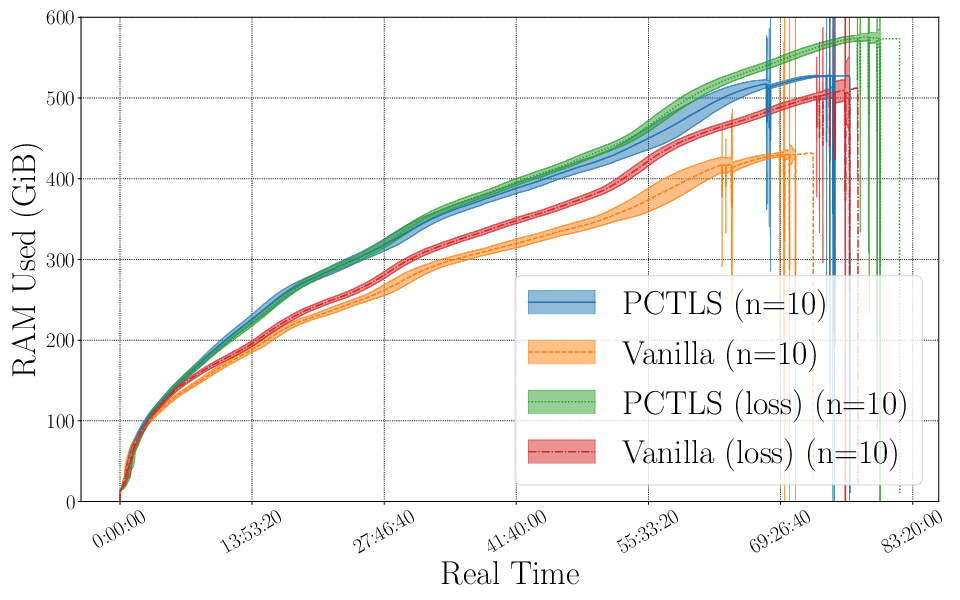

In [20]:
WImage(filename="./paper-performance-ram.pdf", resolution=60)

In [21]:
WImage(filename="./paper-performance-circuit_build_time.pdf", resolution=60)

In [22]:
WImage(filename="./paper-performance-transfer_time_51200.pdf", resolution=60)

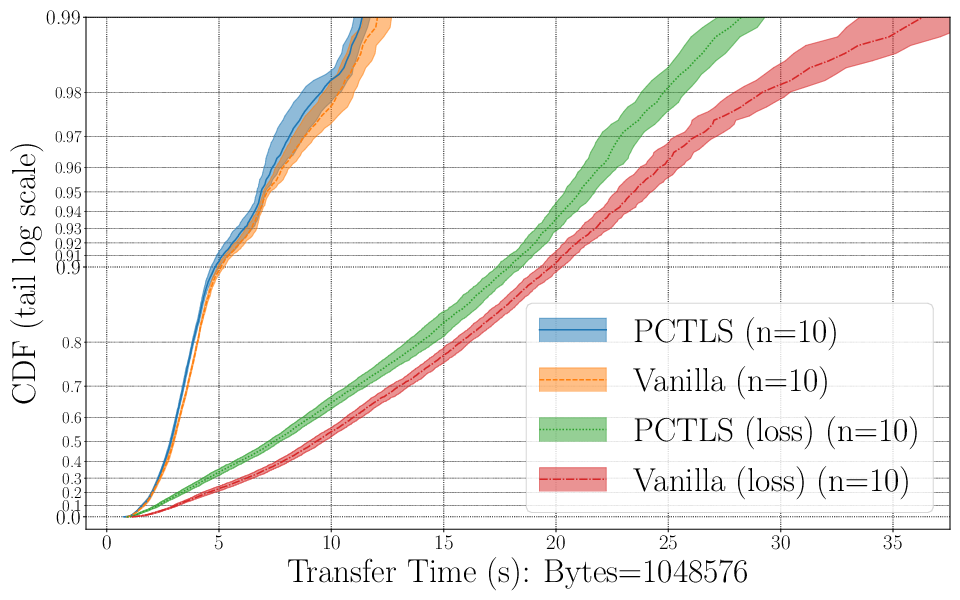

In [23]:
WImage(filename="./paper-performance-transfer_time_1048576.pdf", resolution=60)

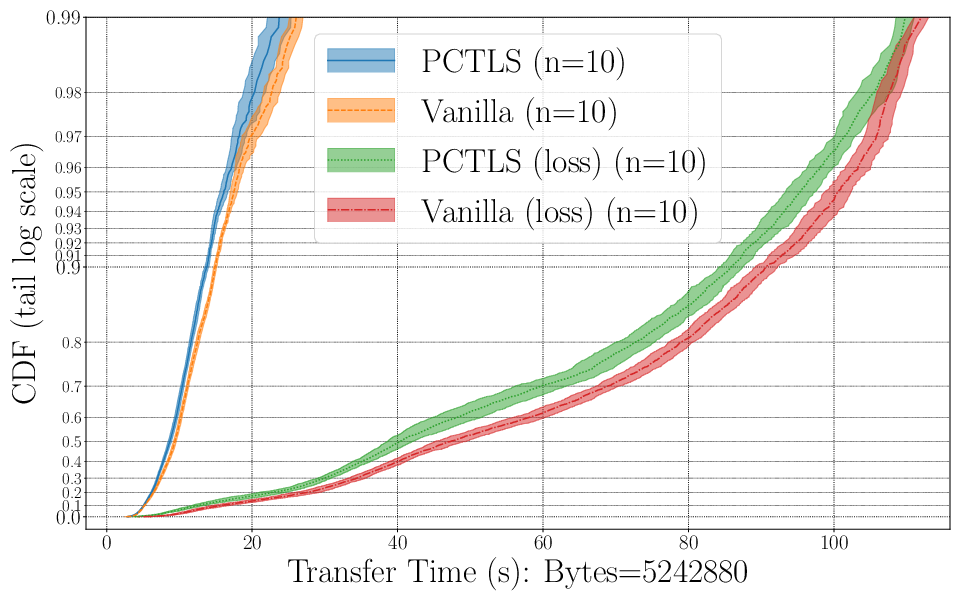

In [24]:
WImage(filename="./paper-performance-transfer_time_5242880.pdf", resolution=60)